In [1]:
import sys
sys.path.append('/gpfs/loomis/home.grace/ys668/software/koza4ok')
import uproot4 as uproot
import math
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, auc, roc_curve, precision_recall_curve, plot_precision_recall_curve
from skTMVA import convert_bdt_sklearn_tmva
from joblib import dump, load
import pickle

In [2]:
mltreeroot = uproot.open("/gpfs/loomis/home.grace/ys668/output/seed_1C0B_mltree.root" )
mltree = mltreeroot["Stg"]

In [3]:
loc = mltree.arrays( [ "Crit2_RZRatio_x1", "Crit2_RZRatio_y1", "Crit2_RZRatio_z1", "Crit2_RZRatio_x2", "Crit2_RZRatio_y2",\
                      "Crit2_RZRatio_z2", "Crit2_RZRatio_trackIds" ], library='pd')

In [4]:
loc

Crit2_RZRatio_x1  Crit2_RZRatio_y1  Crit2_RZRatio_z1  \
entry subentry                                                         
0     0                -0.935607         25.021116        303.704987   
      1                -0.935607         25.021116        303.704987   
      2                -0.935607         25.021116        303.704987   
      3                -0.935607         25.021116        303.704987   
      4                -0.935607         25.021116        303.704987   
...                          ...               ...               ...   
19999 717              10.665518          3.714659        349.404999   
      718              10.665518          3.714659        349.404999   
      719              10.665518          3.714659        349.404999   
      720              10.665518          3.714659        349.404999   
      721              10.665518          3.714659        349.404999   

                Crit2_RZRatio_x2  Crit2_RZRatio_y2  Crit2_RZRatio_z2  \
entry subentry                                                         
0     0               -45.055008         26.090652        280.904999   
      1                -0.917182         23.294699        280.904999   
      2                 7.543242         20.994434        280.904999   
      3                14.245992         18.194252        280.904999   
      4               -39.714920        -25.209108        280.904999   
...                          ...               ...               ...   
19999 717              33.661144        -14.316016        326.605011   
      718              13.254014         -9.626814        326.605011   
      719              13.012218        -10.416829        326.885010   
      720              24.579853         -2.190582        326.605011   
      721              36.045284        -44.976093        326.605011   

                Crit2_RZRatio_trackIds  
entry subentry                          
0     0                             -1  
      1                             37  
      2                             -1  
      3                             -1  
      4                             -1  
...                                ...  
19999 717                           -1  
      718                           -1  
      719                           -1  
      720                           -1  
      721                           -1  

[12877245 rows x 7 columns]

In [5]:
hit2_obs = {}
hit2_obs['true'] = loc[[ "Crit2_RZRatio_x1", "Crit2_RZRatio_y1", "Crit2_RZRatio_z1", "Crit2_RZRatio_x2", "Crit2_RZRatio_y2", "Crit2_RZRatio_z2"]][loc.Crit2_RZRatio_trackIds != -1]
hit2_obs['false'] = loc[[ "Crit2_RZRatio_x1", "Crit2_RZRatio_y1", "Crit2_RZRatio_z1", "Crit2_RZRatio_x2", "Crit2_RZRatio_y2", "Crit2_RZRatio_z2"]][loc.Crit2_RZRatio_trackIds == -1]

In [6]:
X2 = np.concatenate((hit2_obs['true'], hit2_obs['false']))
y2 = np.concatenate((np.ones(hit2_obs['true'].shape[0]),
                    np.zeros(hit2_obs['false'].shape[0])))

In [7]:
X2_dev,X2_eval, y2_dev,y2_eval = train_test_split(X2, y2, test_size=0.33, random_state=42)
X2_train,X2_test, y2_train,y2_test = train_test_split(X2_dev, y2_dev, test_size=0.33, random_state=492)

In [ ]:
dt = DecisionTreeClassifier(max_depth=3)
bdt2 = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=800,
                         learning_rate=0.5)

bdt2.fit(X2_train, y2_train)

In [8]:
filename = 'bdt2_loc.sav'
bdt2 = pickle.load(open(filename, 'rb'))

In [9]:
y2_predicted = bdt2.predict(X2_test)
print (classification_report(y2_test, y2_predicted,
                            target_names=["fake", "real"]))
print ("Area under ROC curve: %.4f"%(roc_auc_score(y2_test,
                                                  bdt2.decision_function(X2_test))))

/gpfs/loomis/project/caines/ys668/conda_envs/my_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        fake       0.95      1.00      0.98   2718792
        real       0.00      0.00      0.00    128367

    accuracy                           0.95   2847159
   macro avg       0.48      0.50      0.49   2847159
weighted avg       0.91      0.95      0.93   2847159

Area under ROC curve: 0.7053


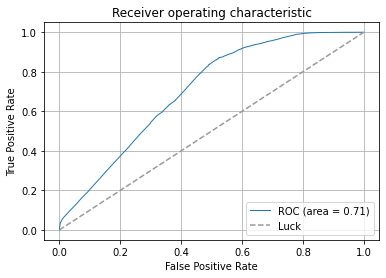

In [10]:
decisions = bdt2.decision_function(X2_test)
fpr, tpr, thresholds = roc_curve(y2_test, decisions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)'%(roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

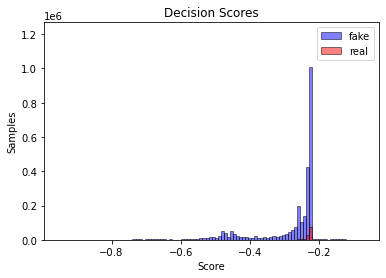

In [11]:
plot_colors = "br"
plot_step = 0.02
class_names = 'fake','real'

plot_range = (decisions.min(), decisions.max())
for i, n, c in zip(range(2), class_names, plot_colors):
    plt.hist(decisions[y2_test == i],
             bins=100,
             range=plot_range,
             facecolor=c,
             label=n,
             alpha=.5,
             edgecolor='k')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, y1, y2 * 1.2))
plt.legend(loc='upper right')
plt.ylabel('Samples')
plt.xlabel('Score')
plt.title('Decision Scores')

plt.show()